In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from astropy import table
import seaborn as sns
import numpy as np
import astropy
from astropy.cosmology import FlatLambdaCDM
import h5py
cosmo = FlatLambdaCDM(H0=70, Om0=0.315) #SNANA default cosmology
import warnings
warnings.filterwarnings("ignore")
#plotting functionality!!
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [94]:
def ia_rate(z):
    rates = []
    for zstep in z:
        if zstep<1:
            rates.append(2.5e-5*(1+zstep)**1.5)
        elif zstep>=1:
            rates.append(9.7e-5*(1+zstep)**-0.5)
    return(np.asarray(rates))
        
def cc_rate(z):
    rates = []
    rates.append(0.0091*0.7**2*0.015*(1+z)**5/(1+((1+z)/1.5)**6.1))
    return(np.asarray(rates))

def collect_snana_outputs(path): #path may be single or list
    if type(path)==str:
        headfiles = sorted(glob.glob(path+ '*HEAD.FITS*'))
        photfiles = sorted(glob.glob(path+ '*PHOT.FITS*'))
    elif type(path)==list:
        headfiles = []
        photfiles = []
        for p in path:
            headfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS*')))
            photfiles.extend(sorted(glob.glob(p+ '*HEAD.FITS*')))
    c=0
    for file in headfiles:
        if c==0:
            headfile = table.Table.read(file, format='fits').to_pandas()
        else:
            headfile=headfile.append(table.Table.read(file, format='fits').to_pandas())
        c+=1
    return headfile

In [137]:
scotchpath = "/global/cscratch1/sd/mlokken/sn_hostenv/scotch_submitted/scotch_z3.hdf5"

In [138]:
f    = h5py.File(scotchpath, "r")

In [139]:
ttable = f['TransientTable']
htable = f['HostTable']

In [140]:
htable.keys()

<KeysViewHDF5 ['AGN', 'KN', 'SLSN-I', 'SNII', 'SNIIb', 'SNIa', 'SNIb', 'SNIc', 'TDE']>

In [141]:
ttable['SNIa'].keys()

<KeysViewHDF5 ['SNIa-91bg', 'SNIa-SALT2', 'SNIax']>

In [142]:
cl = 'SNIa'
if cl=='CC':
    z = np.concatenate((np.array(htable['SNII']['z']),np.array(htable['SNIc']['z']),np.array(htable['SNIIb']['z']),np.array(htable['SNIb']['z'])))
elif cl=='SNIa':
    z = np.array(ttable['SNIa']['SNIa-SALT2']['z'])
else:
    z = np.array(htable[cl]['z'])
f.close()

In [143]:
# # expected increase with redshift
# zarr = np.linspace(0,3, 100)
# plt.plot(zarr,cosmo.differential_comoving_volume(z)/(1+z))
# plt.xlabel("z")
# plt.ylabel("dV")
# plt.title("Differential comoving volume")

(array([ 21037., 107074., 216504., 296860., 288200., 266621., 243071.,
        209841., 186832., 163960.]),
 array([0.02574539, 0.31817052, 0.61059564, 0.9030208 , 1.1954459 ,
        1.487871  , 1.7802962 , 2.0727212 , 2.3651464 , 2.6575716 ,
        2.9499967 ], dtype=float32),
 <BarContainer object of 10 artists>)

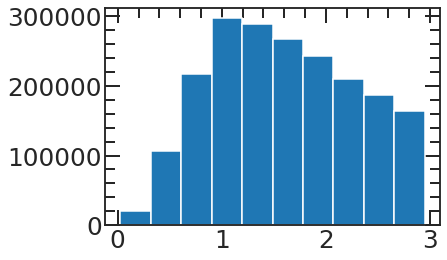

In [144]:
plt.hist(z)

In [145]:
def volumetric_rate(z, skyfrac):
    hist, bin_edges = np.histogram(z, bins=20)
    vol_rates = []
    zavg      = []
    for i in range(len(bin_edges)-1):
        zstep = (bin_edges[i+1]+bin_edges[i])/2.
        zavg.append(zstep)
        dz = bin_edges[i+1]-bin_edges[i]
        dV = (cosmo.comoving_volume(bin_edges[i+1])-cosmo.comoving_volume(bin_edges[i]))*skyfrac
        # dV = cosmo.differential_comoving_volume(zstep)*dz
        vol_rates.append((hist[i]/dV).value*(zstep+1))
    return(np.asarray(vol_rates), np.asarray(zavg)) # returns N/Mpc^3/day

In [146]:
vol_rates, z_avg = volumetric_rate(z, 1) # our simulation generates events just at a single point, but imagine these are spread out across the fullsky

In [147]:
if cl=='SNIa':
    n_exp = 21773710 # n_expected from Table B1
if cl=='KN':
    n_exp = 122640*2
if cl=='CC':
    n_exp = 96525345
scale = n_exp/365/(len(z)) # expected number of events to z=3 per year, converted to # per day, compared to the number there actually are
vol_rates_scaled = vol_rates * scale # our volumetric rates per Mpc^3 per day, times number expected over number we have
vol_rate_peryear = vol_rates_scaled * 365 # our volumetric rates per year

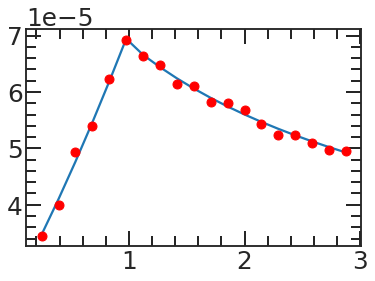

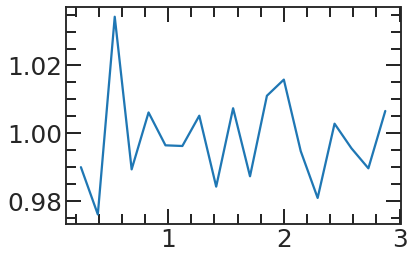

In [148]:
z_model = np.linspace(0,3,100)
if cl=='SNIa':
    plt.plot(z_avg[1:], ia_rate(z_avg[1:]))
    plt.plot(z_avg[1:], vol_rate_peryear[1:], 'ro') #rates per Mpc^3 per day * scale * days per year; these should match.
    plt.show()
    plt.clf()
    plt.plot(z_avg[1:], vol_rate_peryear[1:]/ia_rate(z_avg[1:]))

In [149]:
if cl=='KN':
    # from Plasticc paper: 6e-6 is vol rate per year per full sky
    plt.plot(z_model, np.full(len(z_model),320e-9*2))
    plt.plot(z_avg[1:], vol_rate_peryear[1:], 'ro')


In [134]:
if cl=='CC':
    plt.plot(z_avg[1:], np.ravel(cc_rate(z_avg[1:])))
    plt.plot(z_avg[1:], vol_rate_peryear[1:], 'ro') #rates per Mpc^3 per day * scale * days per year; these should match.
    plt.show()
    plt.clf()
    plt.plot(z_avg[1:], vol_rate_peryear[1:]/np.ravel(cc_rate(z_avg[1:])))

In [56]:
# expected increase with redshift
z = np.linspace(0,3, 100)

In [ ]:
def volume(z, dz):
    dr  = cosmo.angular_diameter_distance_z1z2(z, z+dz)
    r   = cosmo.angular_diameter_distance(z)
    vol = 4*np.pi*r**2*dr
    return(vol)

In [ ]:
v_of_z = volume(z, z[1]-z[0])

In [ ]:
plt.plot(z,v_of_z)

Text(0.5, 1.0, 'Differential comoving volume')

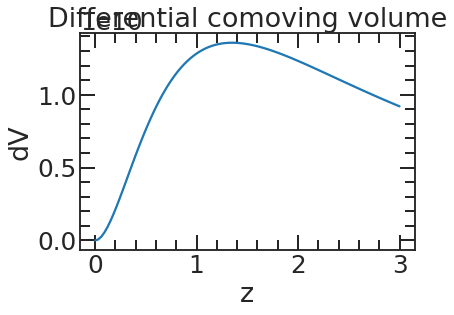

In [14]:
plt.plot(z,cosmo.differential_comoving_volume(z)/(1+z))
plt.xlabel("z")
plt.ylabel("dV")
plt.title("Differential comoving volume")